## Figures

- Figure 5 C
- Figure S6 B,C
- Supplementary movie 1

## Required files
- `{models_dir}/{exp}/motif-simulation/spacing;correct=True.pkl`
- `{models_dir}/{exp}/motif-simulation/spacing;correct=False.pkl`

## Produced files

`fdir = f'{ddir}/figures/modisco/{exp}/spacing/'`

- Figure 5C
  - `{fdir}/simulated.short-range.Nanog<>Sox2.strand_orientation={strand}.pdf`
  - `{fdir}/simulated.long-range.Oct4-Sox2.strand_orientation={strand}.pdf`
- Figure S6C
  - `{fdir}/all-pairs.bleed-through-corrected.strand-specific.pdf`
- Supplementary movie 1
  - `{fdir}/gifs/{motif_pair_name}.gif`

In [1]:
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE,FALSE,5'

In [2]:
# Parameters
exp = "nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE,FALSE,2"


### Load the model

In [3]:
from basepair.imports import *
from basepair.exp.paper.config import *
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs, motif_pair_dfi

Using TensorFlow backend.


In [4]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/spacing/')

motifs = ['Oct4-Sox2',
         'Oct4',
         'Oct4-Oct4',
         'Sox2',
         'Nanog',
         'Nanog-alt',
         'Klf4',
         'Klf4-long',
         'B-box',
         'Zic3',
         'Essrb']

profile_mapping = {'Oct4-Sox2': 'Oct4',
                 'Oct4': 'Oct4',
                 'Oct4-Oct4': 'Oct4',
                 'Sox2': 'Sox2',
                 'Nanog': 'Nanog',
                 'Nanog-alt': 'Nanog',
                 'Klf4': 'Klf4',
                 'Klf4-long': 'Klf4',
                 'B-box': 'Oct4',
                 'Zic3': 'Nanog',
                 'Essrb': 'Oct4'}

In [5]:
from config import experiments

In [6]:
imp_score = experiments[exp]['imp_score']

In [7]:
!mkdir -p {fdir}

In [8]:
%config InlineBackend.figure_format = 'retina'

In [9]:
paper_config()

In [10]:
import os
import pandas as pd
import types
import numpy as np
from basepair.seqmodel import SeqModel
from basepair.BPNet import BPNetSeqModel
from collections import OrderedDict
from basepair.preproc import rc_seq
from basepair.exp.chipnexus.simulate import (insert_motif, generate_sim, plot_sim, generate_seq,
                                             model2tasks, motif_coords, interactive_tracks, plot_motif_table,
                                             plot_sim_motif_col)
from concise.preprocessing import encodeDNA
from basepair.exp.paper.config import models_dir
from basepair.config import get_data_dir, create_tf_session
from basepair.utils import write_pkl
import argparse
import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.NullHandler())


# --------------------------------------------
# Motif configuration
motif_seqs = OrderedDict([
    ("Oct4-Sox2", 'TTTGCATAACAA'),
    ("Oct4", "TATGCAAAT"),
    ("Oct4-Oct4", "TATGCATATGCATA"),
    ("Sox2", "GAACAATGG"),
    ("Nanog", "AGCCATCA"),
    ("Nanog-alt", "GATGGCCCATTTCCT"),
    ("Klf4", "CCACGCCC"),
    ("Klf4-long", "GCCCCGCCCCGCCC"),
    ("B-box", "CCGGGGTTCGAACCCGGG"),
    ("Zic3", "TCTCAGCAGGTAGCA"),
    ("Essrb", "TGACCTTGACCTT")
])

# get also the rc motifs
rc_motif_seqs = OrderedDict([
    (m + "/rc", rc_seq(v))
    for m, v in motif_seqs.items()
])
all_motif_seqs = OrderedDict(list(motif_seqs.items()) + list(rc_motif_seqs.items()))

center_coords = [485, 520]
repeat = 128

## In silico instances

In [11]:
!ls {models_dir}/{exp}/motif-simulation/

spacing;correct=True.pkl


In [12]:
# corrected
sim_df_d_norm, sim_res_dict_d_norm = read_pkl(f"{models_dir}/{exp}/motif-simulation/spacing;correct=True.pkl")

## Visualize motif pairs

In [13]:
from basepair.exp.chipnexus.spacing import comp_strand_compbination

def get_xy_sim_single(sim_df_d, motif_pair, feature, orientation, profile_mapping):
    # For Nanog, always explicilty swap the orientation
    orientation_pair = [orientation[0], orientation[1]]
    
    mp = list(deepcopy(motif_pair))
    if orientation_pair[0] == "-":
        mp[0] = mp[0] + "/rc"
    if orientation_pair[1] == "-":
        mp[1] = mp[1] + "/rc"
        
    df = sim_df_d[mp[0]]  # choose the central motif
    df = df[df.motif == mp[1]]  # choose the side motif
    
    df = df[df.distance < 150]
    
    # select the task
    df = df[df.task == profile_mapping[motif_pair[0]]]        
    return df.distance.values, df[feature].values
    
def get_xy_sim(sim_df_d, motif_pair, feature, orientation, profile_mapping):
    x1,y1 = get_xy_sim_single(sim_df_d, motif_pair, feature, orientation, profile_mapping)
    x2,y2 = get_xy_sim_single(sim_df_d, list(reversed(motif_pair)), feature, orientation, profile_mapping)
    return x1, y1, y2

In [14]:
pairs = get_motif_pairs(motifs)

In [15]:
tested_motif_pairs = [p for p in pairs if p[0] in sim_df_d_norm and p[1] in sim_df_d_norm]

## Figure 5B

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


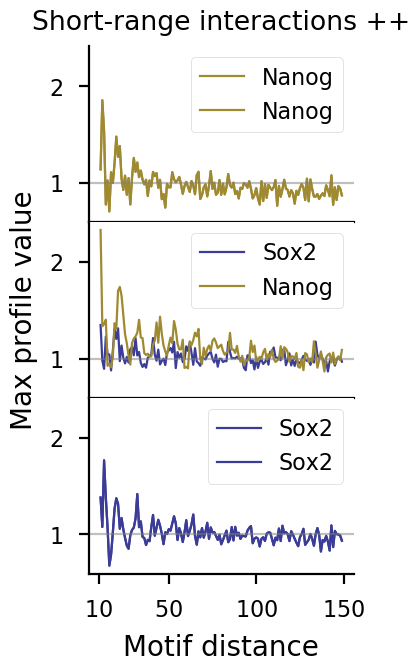

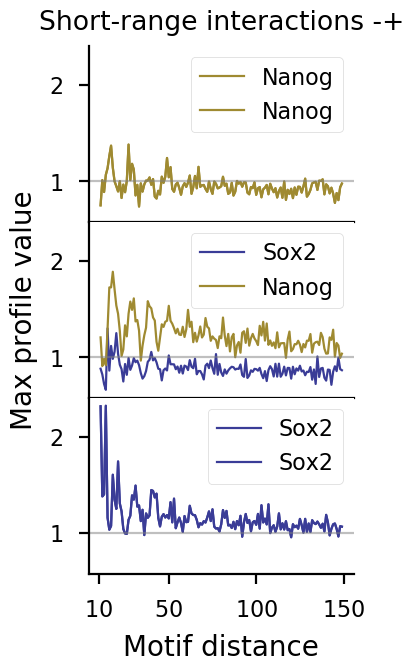

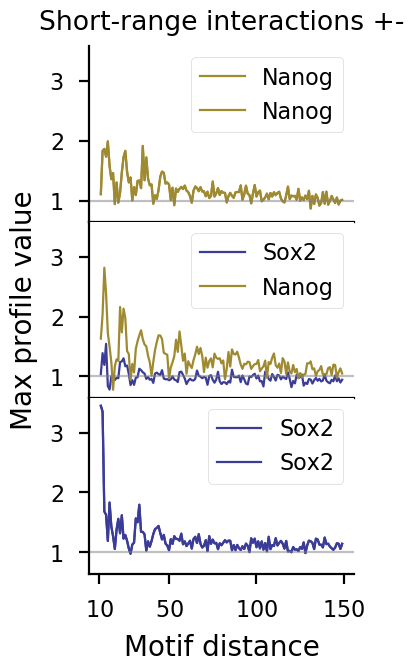

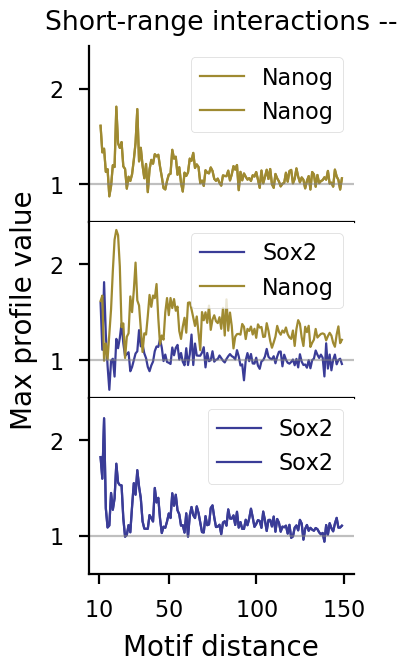

In [16]:
for strand in ['++', '-+', '+-', '--']:
    fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                             sharex=True, 
                             sharey=True,
                             gridspec_kw=dict(wspace=0, hspace=0))
    # motif_pair = ['Oct4-Sox2', 'Sox2']
    for i, motif_pair in enumerate([['Nanog', 'Nanog'], 
                                    ['Sox2', 'Nanog'],
                                    ['Sox2', 'Sox2']]):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand, profile_mapping)
        ax = axes[i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]]);
        if i == 0:
            ax.set_title(f"Short-range interactions {strand}")
        ax.axhline(1, color='grey', alpha=0.5)
        if i == 1:
            ax.set_ylabel("Max profile value")
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[-1].set_xlabel("Motif distance")
    axes[-1].set_xticks([10, 50, 100, 150]);
    fig.savefig(fdir / f'simulated.short-range.Nanog<>Sox2.strand_orientation={strand}.pdf')

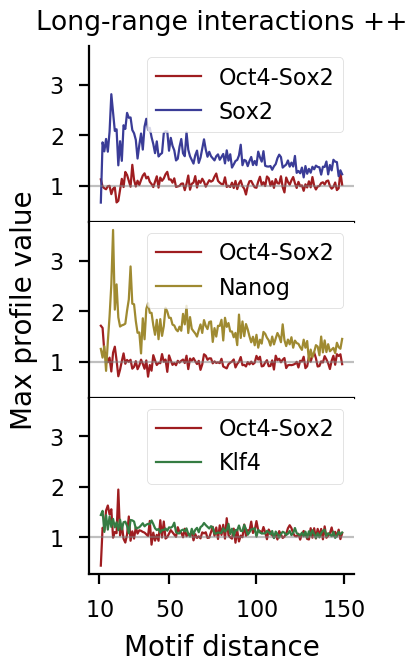

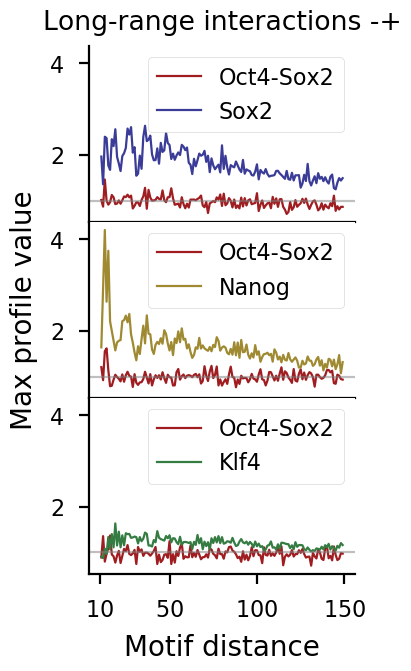

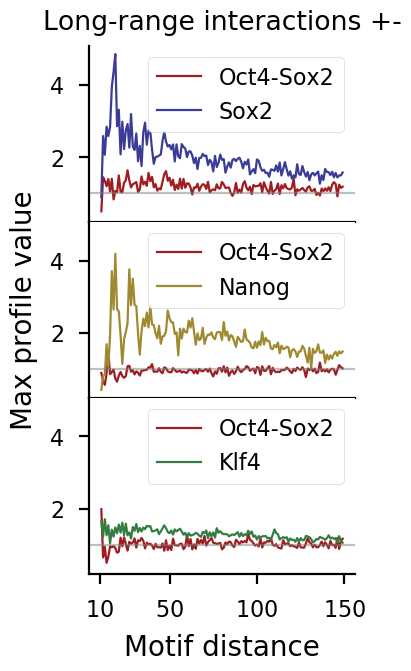

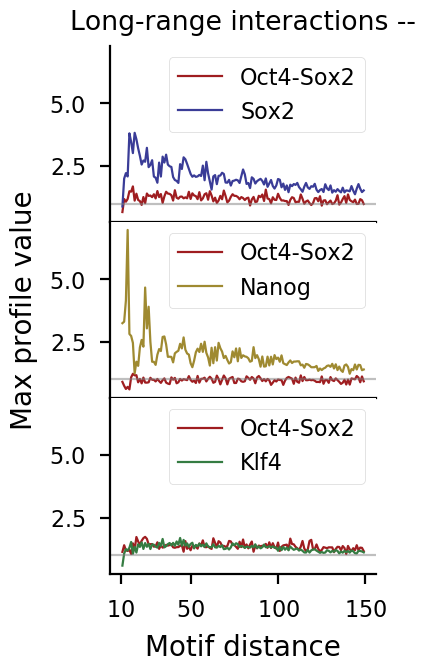

In [17]:
for strand in ['++', '-+', '+-', '--']:

    fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                             sharex=True, 
                             sharey=True,
                             gridspec_kw=dict(wspace=0, hspace=0))
    # motif_pair = ['Oct4-Sox2', 'Sox2']
    for i, motif_pair in enumerate([['Oct4-Sox2', 'Sox2'], 
                                    ['Oct4-Sox2', 'Nanog'],
                                    ['Oct4-Sox2', 'Klf4']]):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand, profile_mapping)
        ax = axes[i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]]);
        if i == 0:
            ax.set_title(f"Long-range interactions {strand}")
        ax.axhline(1, color='grey', alpha=0.5)
        if i == 1:
            ax.set_ylabel("Max profile value")
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[-1].set_xlabel("Motif distance")
    axes[-1].set_xticks([10, 50, 100, 150]);
    fig.savefig(fdir / f'simulated.long-range.Oct4-Sox2.strand_orientation={strand}.pdf')

## Generate per-motif plots

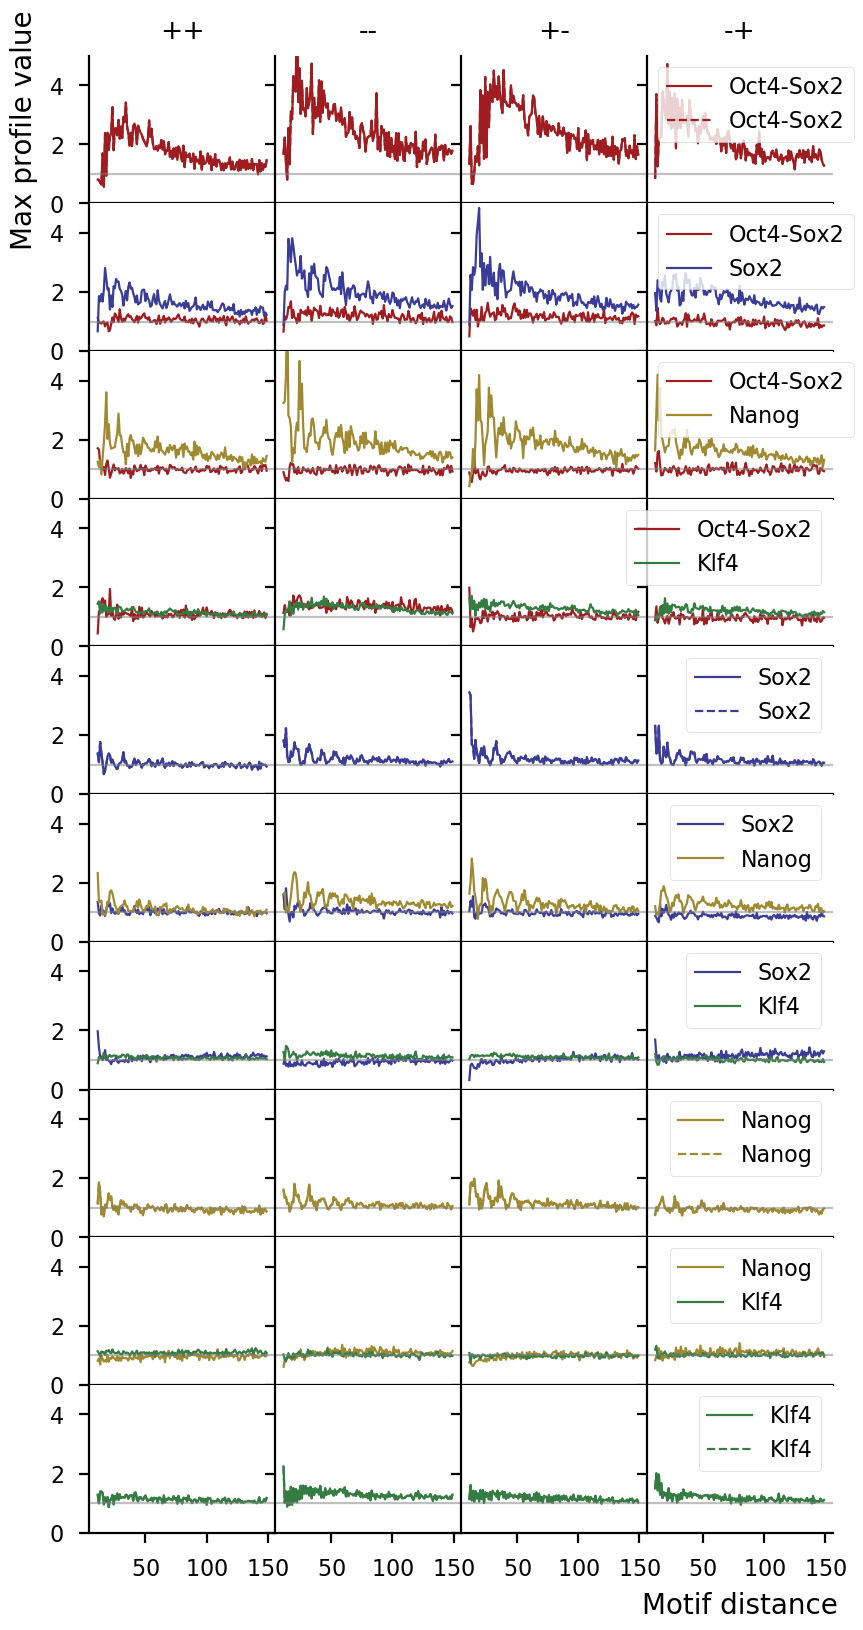

In [18]:
ymax = 5
columns = 4
plot_pairs = get_motif_pairs(['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4'])
rows = len(plot_pairs)
fig, axes = plt.subplots(rows, columns, figsize=get_figsize(.7, 1/5*len(plot_pairs)), 
                         sharex=True, 
                         sharey=True,
                         gridspec_kw=dict(wspace=0, hspace=0))

for j, motif_pair in enumerate(plot_pairs):
    for i, strand_orientation in enumerate(['++', '--', '+-', '-+']):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand_orientation, profile_mapping)
        ax = axes[j, i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]], 
                linestyle='dashed' if motif_pair[0] == motif_pair[1] else 'solid');  # only dashed for homotypic interactions
        ax.set_ylim([0, ymax])
        ax.axhline(1, color='grey', alpha=0.5)
        if j == 0:
            ax.set_title(strand_orientation)
            if i ==0 :
                ax.set_ylabel("Max profile value")
            
        if i == 3:
            ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i % rows == rows-1:
            axes[i].set_xticks([10, 50, 100, 150]);
ax.set_xlabel("Motif distance")
motif_pair_name = '<>'.join(motif_pair)
fig.savefig(fdir / f'all-pairs.bleed-through-corrected.strand-specific.pdf')